<a href="https://colab.research.google.com/github/patilsubhas184/candidate_sourcing_tracker/blob/main/Retail_Sales_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from google.colab import files
files.upload()



Saving retail_sales_dataset.csv to retail_sales_dataset.csv


{'retail_sales_dataset.csv': b'Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount\r\n1,2023-11-24,CUST001,Male,34,Beauty,3,50,150\r\n2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000\r\n3,2023-01-13,CUST003,Male,50,Electronics,1,30,30\r\n4,2023-05-21,CUST004,Male,37,Clothing,1,500,500\r\n5,2023-05-06,CUST005,Male,30,Beauty,2,50,100\r\n6,2023-04-25,CUST006,Female,45,Beauty,1,30,30\r\n7,2023-03-13,CUST007,Male,46,Clothing,2,25,50\r\n8,2023-02-22,CUST008,Male,30,Electronics,4,25,100\r\n9,2023-12-13,CUST009,Male,63,Electronics,2,300,600\r\n10,2023-10-07,CUST010,Female,52,Clothing,4,50,200\r\n11,2023-02-14,CUST011,Male,23,Clothing,2,50,100\r\n12,2023-10-30,CUST012,Male,35,Beauty,3,25,75\r\n13,2023-08-05,CUST013,Male,22,Electronics,3,500,1500\r\n14,2023-01-17,CUST014,Male,64,Clothing,4,30,120\r\n15,2023-01-16,CUST015,Female,42,Electronics,4,500,2000\r\n16,2023-02-17,CUST016,Male,19,Clothing,3,500,1500\r\n17,2023-04-22,CUST017,Female,27,Clothing,

In [17]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [18]:
!kaggle datasets download -d mohammadtalib786/retail-sales-dataset


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [19]:
!unzip retail-sales-dataset.zip


unzip:  cannot find or open retail-sales-dataset.zip, retail-sales-dataset.zip.zip or retail-sales-dataset.zip.ZIP.


In [21]:
import pandas as pd

df = pd.read_csv("retail_sales_dataset.csv")
df.head()


,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    1000 non-null   int64 
 1   Date              1000 non-null   object
 2   Customer ID       1000 non-null   object
 3   Gender            1000 non-null   object
 4   Age               1000 non-null   int64 
 5   Product Category  1000 non-null   object
 6   Quantity          1000 non-null   int64 
 7   Price per Unit    1000 non-null   int64 
 8   Total Amount      1000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 70.4+ KB


In [24]:
# Cell 4 — standardize names and detect columns
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
print("columns:", list(df.columns))

# auto-detect
date_col = next((c for c in df.columns if 'date' in c), None)
quantity_col = next((c for c in df.columns if 'quantity' in c or 'qty' in c), None)
price_col = next((c for c in df.columns if any(x in c for x in ['price','unit','amount','rate','price_per_unit','unitprice'])), None)

print("Detected -> date:", date_col, ", quantity:", quantity_col, ", price:", price_col)


columns: ['transaction_id', 'date', 'customer_id', 'gender', 'age', 'product_category', 'quantity', 'price_per_unit', 'total_amount']
Detected -> date: date , quantity: quantity , price: price_per_unit


In [25]:
# Cell 5 — cleaning & derive columns
import numpy as np

# parse date
if date_col:
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

# numeric conversions
for c in [quantity_col, price_col]:
    if c and c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# drop duplicates
df = df.drop_duplicates()

# drop rows missing essential info (date and at least one of customer or invoice)
essential = [date_col]
df = df.dropna(subset=essential)

# optional: drop negative/zero quantities (if these are returns and you want sales only)
if quantity_col in df.columns:
    df = df[df[quantity_col] > 0]

# compute sales_amount if possible
if quantity_col in df.columns and price_col in df.columns:
    df['sales_amount'] = df[quantity_col] * df[price_col]
else:
    df['sales_amount'] = np.nan

# temporal features
if date_col:
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['order_month'] = df[date_col].dt.to_period('M')

print("After cleaning:", df.shape)
display(df.head())


After cleaning: (1000, 13)


,transaction_id,date,customer_id,gender,age,product_category,quantity,price_per_unit,total_amount,sales_amount,year,month,order_month
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150,150,2023,11,2023-11
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000,1000,2023,2,2023-02
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30,30,2023,1,2023-01
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500,500,2023,5,2023-05
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100,100,2023,5,2023-05


In [28]:
# Cell 6 — descriptive stats for key numeric columns
from scipy import stats

metrics = []
for c in [quantity_col, price_col, 'sales_amount']:
    if c and c in df.columns:
        metrics.append(c)

desc = df[metrics].describe().T
desc['mode'] = df[metrics].mode().iloc[0]  # ✅ FIXED
desc


,count,mean,std,min,25%,50%,75%,max,mode
quantity,1000.0,2.514,1.132734,1.0,1.0,3.0,4.0,4.0,4
price_per_unit,1000.0,179.890,189.681356,25.0,30.0,50.0,300.0,500.0,50
sales_amount,1000.0,456.000,559.997632,25.0,60.0,135.0,900.0,2000.0,50


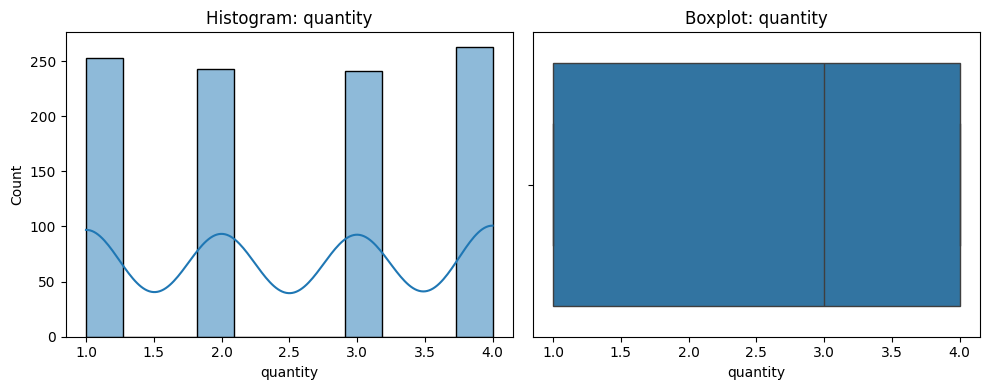

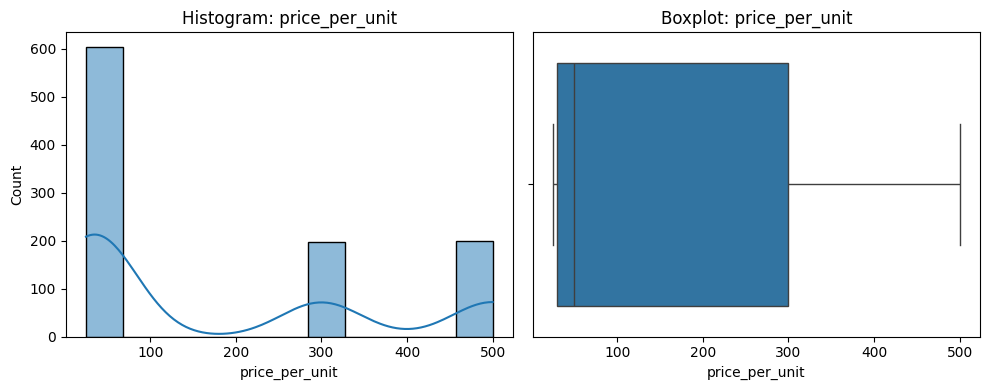

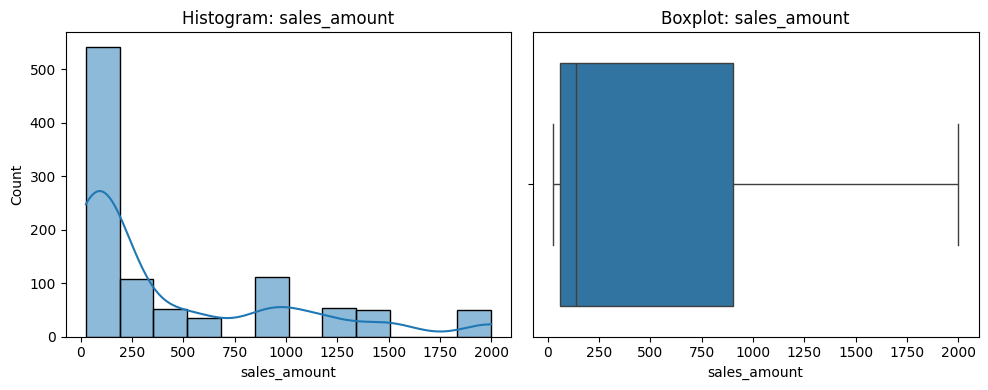

In [29]:
# Cell 7 — histograms and boxplots
import matplotlib.pyplot as plt
import seaborn as sns

for c in metrics:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    sns.histplot(df[c].dropna(), kde=True)
    plt.title(f'Histogram: {c}')
    plt.subplot(1,2,2)
    sns.boxplot(x=df[c].dropna())
    plt.title(f'Boxplot: {c}')
    plt.tight_layout()
    plt.show()



/tmp/ipython-input-516415889.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = df.set_index(date_col)['sales_amount'].resample('M').sum()


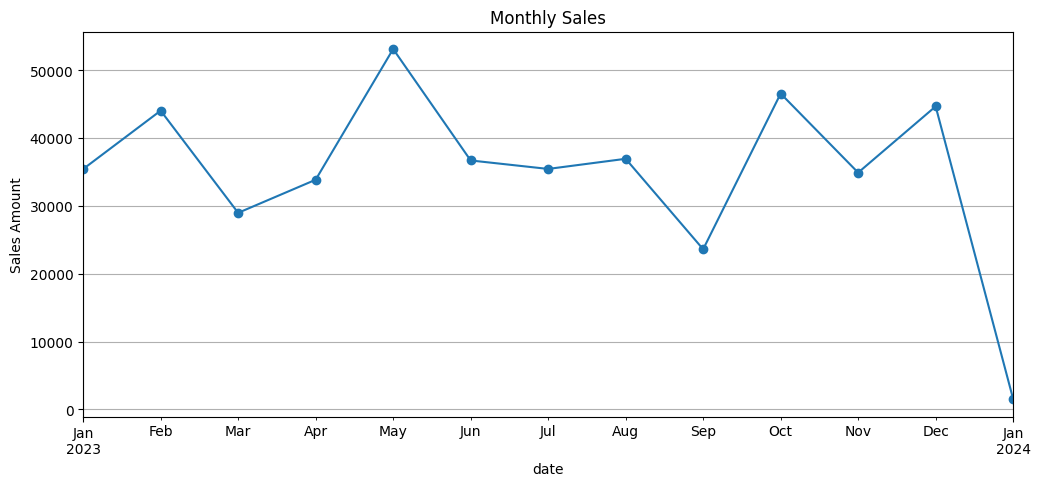

In [30]:
# Cell 8 — monthly sales line plot
if 'sales_amount' in df.columns and not df['sales_amount'].isna().all():
    ts = df.set_index(date_col)['sales_amount'].resample('M').sum()
    plt.figure(figsize=(12,5))
    ts.plot(marker='o')
    plt.title('Monthly Sales')
    plt.ylabel('Sales Amount')
    plt.grid(True)
    plt.show()
else:
    print("sales_amount not available to build time series.")


In [32]:
# Cell 9 — RFM
if 'customerid' in df.columns and 'sales_amount' in df.columns:
    snapshot_date = df[date_col].max() + pd.Timedelta(days=1)
    rfm = df.groupby('customerid').agg(
        recency = (date_col, lambda x: (snapshot_date - x.max()).days),
        frequency = ('invoice_no' if 'invoice_no' in df.columns else date_col, 'nunique'),
        monetary = ('sales_amount','sum')
    ).reset_index()
    # if frequency came from date_col, rename
    if 'recency' in rfm.columns:
        display(rfm.describe().T)
    display(rfm.head())
else:
    print("Need customerid and sales_amount for RFM.")


Need customerid and sales_amount for RFM.


In [34]:
# Cell 10 — top products
if 'description' in df.columns and 'sales_amount' in df.columns:
    prod = df.groupby(['stockcode' if 'stockcode' in df.columns else 'description', 'description' if 'description' in df.columns else 'stockcode']).agg(
        total_revenue=('sales_amount','sum'),
        total_qty=(quantity_col,'sum'),
        orders=('invoice_no' if 'invoice_no' in df.columns else date_col, 'nunique')
    ).reset_index().sort_values('total_revenue', ascending=False)
    display(prod.head(20))
else:
    print("No product columns found.")


No product columns found.


In [36]:
# Cell 11 — heatmap month x country
if 'country' in df.columns and 'sales_amount' in df.columns:
    pivot = df.reset_index().groupby([df.index.month, 'country'])['sales_amount'].sum().unstack(fill_value=0)
    plt.figure(figsize=(14,8))
    sns.heatmap(pivot, annot=False)
    plt.title('Month vs Country Sales Heatmap')
    plt.ylabel('Month')
    plt.show()
else:
    print("Need country column for this heatmap.")


Need country column for this heatmap.
